# Workflow to calibrate OGGM with geodetic data and run volume projections with your own climate dataset!

- We basically do what `run_prepro_levels` of prepro_levels.py (->link) would do if `start_level=2` and if we use `match_geodetic_mb_per_glacier=True`
- here we use the W5E5 climate and a special glacier-specific precipitation factor

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib

import statsmodels as stats
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

cfg.initialize(logging_level='WORKFLOW')
work_dir = utils.gettempdir(dirname='OGGM-geodetic_calib')
cfg.PATHS['working_dir'] = work_dir
sum_dir = work_dir 
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

/home/lilianschuster/oggm/oggm/cfg.py:386: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2022-05-17 18:49:17: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-05-17 18:49:17: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-05-17 18:49:17: oggm.cfg: Multiprocessing: using all available processors (N=8)


### 1. Initialize gdir and process your climate data

In [2]:
cfg.PARAMS['baseline_climate'] = 'GSWP3_W5E5'  # or W5E5 (if you just want data from 1979 onwards!)

match_geodetic_mb_per_glacier = True
cfg.PARAMS['climate_qc_months'] = 0
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1

2022-05-17 18:49:17: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `GSWP3_W5E5`.
2022-05-17 18:49:17: oggm.cfg: PARAMS['climate_qc_months'] changed from `3` to `0`.
2022-05-17 18:49:17: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2022-05-17 18:49:17: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.


In [3]:
df = ['RGI60-11.00897','RGI60-11.01450']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
#gdir = gdirs[0]
workflow.execute_entity_task(tasks.process_climate_data, gdirs)
# could also use instead directly 
# workflow.execute_entity_task(oggm.shop.w5e5.process_gswp3_w5e5_data, gdirs)


2022-05-17 18:49:18: oggm.workflow: init_glacier_directories from prepro level 2 on 2 glaciers.
2022-05-17 18:49:18: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers
2022-05-17 18:49:18: oggm.workflow: Execute entity tasks [process_climate_data] on 2 glaciers


[None, None]

### 2. calibrate MB model of OGGM with geodetic estimates from Hugonnet et al. (2021)

In [4]:
cfg.PARAMS['temp_melt']

-1.0

In [9]:
cfg.PARAMS['prcp_scaling_factor']  # could change it to : 'from_winter_prcp'  to make that clearer?!

2.5

In [10]:
cfg.PARAMS['temp_all_solid']

0.0

In [11]:
cfg.PARAMS['temp_all_liq']

2.0

In [12]:
cfg.PARAMS['temp_default_gradient']

-0.0065

In [13]:
# actually strange why this is still at 10000 per default even if it means that mu_star_calibration_from_geodetic_mb will not work, maybe change that default value???
cfg.PARAMS['max_mu_star'] = 1000  
# we do not need any climate check!
cfg.PARAMS['climate_qc_months'] = 0
utils.get_geodetic_mb_dataframe()  # Small optim to avoid concurrency


2022-05-17 18:49:34: oggm.cfg: PARAMS['max_mu_star'] changed from `10000.0` to `1000`.


,period,area,dmdtda,err_dmdtda,reg,is_cor
rgiid,,,,,,
RGI60-01.00001,2000-01-01_2010-01-01,360000.0,0.021700,0.430000,1,False
RGI60-01.00001,2000-01-01_2020-01-01,360000.0,-0.012800,0.217600,1,False
RGI60-01.00001,2010-01-01_2020-01-01,360000.0,-0.047200,0.394900,1,False
RGI60-01.00002,2000-01-01_2010-01-01,558000.0,-0.168300,0.279200,1,False
RGI60-01.00002,2000-01-01_2020-01-01,558000.0,-0.229000,0.146000,1,False
...,...,...,...,...,...,...
RGI60-19.02751,2000-01-01_2020-01-01,11000.0,-0.136311,0.295265,19,True
RGI60-19.02751,2010-01-01_2020-01-01,11000.0,-0.119835,0.536447,19,True
RGI60-19.02752,2000-01-01_2010-01-01,528000.0,0.121300,0.542100,19,False


In [14]:
# workflow.execute_entity_task(tasks.mu_star_calibration_from_geodetic_mb, gdirs)
# Let's directly calibrate by using prcp. fac from winter prcp. match 
workflow.execute_entity_task(tasks.mu_star_calibration_from_geodetic_mb, gdirs, prcp_fac='from_winter_prcp')


2022-05-17 18:49:35: oggm.workflow: Execute entity tasks [mu_star_calibration_from_geodetic_mb] on 2 glaciers


[None, None]

**just to visualize what is applied internally in `mu_star_calibration_from_geodetic_mb` if using prcp_fac='from_winter_prcp'**

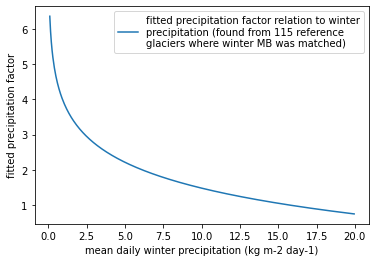

In [29]:
# this is used inside of mu_star_calibration_from_geodetic_mb:
# from MB sandbox calibration to winter MB
# using t_melt=-1, cte lapse rate, monthly resolution
a_log_multiplied = -1.0614
b_intercept = 3.9200
def log_func(x, a, b):
    r = a*np.log(x) +b
    # don't allow extremely low/high prcp. factors!!!
    if np.shape(r) == ():
        if r > 10:
            r = 10
        if r<0.1:
            r=0.1
    else:
        r[r>10] = 10
        r[r<0.1] = 0.1
    return r

winter_prcp_values = np.arange(0.1, 20,0.05)
plt.plot(winter_prcp_values, log_func(winter_prcp_values, a_log_multiplied, b_intercept), label='fitted precipitation factor relation to winter\nprecipitation (found from 115 reference\nglaciers where winter MB was matched)')
plt.ylabel('fitted precipitation factor')
plt.xlabel('mean daily winter precipitation (kg m-2 day-1)') # mean over 1979-2020
plt.legend()

**different prcp. factors were applied depending on the mean daily non-corrected winter prcp**

In [15]:
gdirs[0].read_json('local_mustar')

{'rgi_id': 'RGI60-11.00897',
 't_star': nan,
 'bias': 0,
 'mu_star_per_flowline': [275.602034813723],
 'mu_star_glacierwide': 275.602034813723,
 'mu_star_flowline_avg': 275.602034813723,
 'mu_star_allsame': True,
 'prcp_fac_from_winter_prcp': 3.357136316271367}

In [16]:
gdirs[-1].read_json('local_mustar')

{'rgi_id': 'RGI60-11.01450',
 't_star': nan,
 'bias': 0,
 'mu_star_per_flowline': [303.6193835683732],
 'mu_star_glacierwide': 303.6193835683732,
 'mu_star_flowline_avg': 303.6193835683732,
 'mu_star_allsame': True,
 'prcp_fac_from_winter_prcp': 1.7765151972292408}

In [21]:
# added winter_daily_mean_prcp_1979_2019
clim_stats = utils.compile_climate_statistics(gdirs, winter_daily_mean_prcp=True)
clim_stats['winter_daily_mean_prcp_1979_2019']  # maybe should call that _uncorrected ???

2022-05-17 18:51:56: oggm.utils: Applying global task compile_climate_statistics on 2 glaciers
2022-05-17 18:51:56: oggm.workflow: Execute entity tasks [climate_statistics] on 2 glaciers


rgi_id
RGI60-11.00897    1.6994472904408453
RGI60-11.01450     7.534467999810557
Name: winter_daily_mean_prcp_1979_2019, dtype: object

In [22]:
clim_stats.T

rgi_id,RGI60-11.00897,RGI60-11.01450
rgi_region,11,11
rgi_subregion,11-01,11-01
name,Hintereisferner,
cenlon,10.7584,8.01919
cenlat,46.8003,46.5028
rgi_area_km2,8.036,82.206
glacier_type,Glacier,Glacier
terminus_type,Land-terminating,Land-terminating
status,Glacier or ice cap,Glacier or ice cap
flowline_mean_elev,3026.878257,3075.263293


In [24]:
#  prcp_fac from winter_prcp also saved here:
glacier_stats = utils.compile_glacier_statistics(gdirs)
glacier_stats.T

2022-05-17 18:52:21: oggm.utils: Applying global task compile_glacier_statistics on 2 glaciers
2022-05-17 18:52:21: oggm.workflow: Execute entity tasks [glacier_statistics] on 2 glaciers


rgi_id,RGI60-11.00897,RGI60-11.01450
rgi_region,11,11
rgi_subregion,11-01,11-01
name,Hintereisferner,
cenlon,10.7584,8.01919
cenlat,46.8003,46.5028
rgi_area_km2,8.036,82.206
rgi_year,2003,2003
glacier_type,Glacier,Glacier
terminus_type,Land-terminating,Land-terminating
is_tidewater,False,False


**can estimate fixed geometry**:

- remark: I put that before the ice thickness inversion because you don't need that for that (in prepro level, it is computed after ice thickness inversion)
- need loop here at the moment because prcp. fac not yet incorporated in `compile_fixed_geometry ...`

    **--> instead could use the same approach as with `apparent_mb_from_any_mb`** (see below)


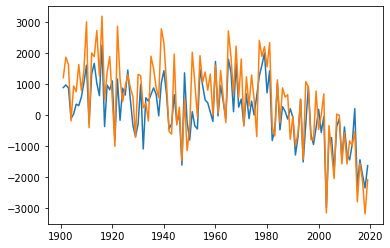

In [25]:
#rgi_reg='test'
#opath = os.path.join(sum_dir, 'fixed_geometry_mass_balance_{}.csv'.format(rgi_reg))
for gdir in gdirs:
    pf = gdir.read_json('local_mustar')['prcp_fac_from_winter_prcp']
    fixed_geom = oggm.core.massbalance.fixed_geometry_mass_balance(gdir, precipitation_factor = pf)
    plt.plot(fixed_geom)

### 3. Ice thickness inversion

- we need to make sure that we use the right prcp. fac here ! 


In [26]:
# inside of OGGM: 
#from oggm.core.massbalance import MultipleFlowlineMassBalance
#mb_model = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True)
#try:
#    pf = gdir.read_json('local_mustar')['prcp_fac_from_winter_prcp']
#    mb_model.prcp_fac = pf
#except KeyError:
#    pass

workflow.execute_entity_task(tasks.apparent_mb_from_any_mb, gdirs)

2022-05-17 18:52:32: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 2 glaciers


[None, None]

In [27]:
from oggm.core.massbalance import MultipleFlowlineMassBalance, PastMassBalance

In [28]:
# Inversion: we match the consensus
border = 80
filter = border >= 20

if border >= 20:
    task_list = [
        tasks.compute_downstream_line,
        tasks.compute_downstream_bedshape,
    ]
    for task in task_list:
        workflow.execute_entity_task(task, gdirs)

workflow.calibrate_inversion_from_consensus(gdirs,
                                            apply_fs_on_mismatch=True,
                                            error_on_mismatch=False,
                                            filter_inversion_output=filter)

2022-05-17 18:52:34: oggm.workflow: Execute entity tasks [compute_downstream_line] on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2022-05-17 18:52:34: oggm.workflow: Applying global task inversion_tasks on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 2 glaciers
2022-05-17 18:52:34: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2022-05-17 18:52:34: oggm.w

,vol_itmix_m3,vol_bsl_itmix_m3,vol_oggm_m3
RGIId,,,
RGI60-11.00897,5.778528e+08,0.0,7.015905e+08
RGI60-11.01450,1.375232e+10,0.0,1.362545e+10


In [29]:
# We get ready for modelling
if border >= 20:
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)
else:
    log.workflow('L3: for map border values < 20, wont initialize glaciers '
                 'for the run.')

2022-05-17 18:52:35: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 2 glaciers


In [30]:
rgi_reg = 'test'

In [31]:
opath = os.path.join(sum_dir, 'glacier_statistics_{}.csv'.format(rgi_reg))
glacier_stats = utils.compile_glacier_statistics(gdirs, path=opath)
opath = os.path.join(sum_dir, 'climate_statistics_{}.csv'.format(rgi_reg))
clim_stats = utils.compile_climate_statistics(gdirs, path=opath, winter_daily_mean_prcp = True)


2022-05-17 18:52:35: oggm.utils: Applying global task compile_glacier_statistics on 2 glaciers
2022-05-17 18:52:35: oggm.workflow: Execute entity tasks [glacier_statistics] on 2 glaciers
2022-05-17 18:52:35: oggm.utils: Applying global task compile_climate_statistics on 2 glaciers
2022-05-17 18:52:35: oggm.workflow: Execute entity tasks [climate_statistics] on 2 glaciers


In [32]:
gdir.read_json('local_mustar')['prcp_fac_from_winter_prcp']


1.7765151972292408

---

## Start of Level 5 tasks

--> ATTENTION: at the moment run_from_climate_data does not take the right prcp. factor ... 
-> I just do a loop here to prescribe the right prcp_fac 

**--> instead could use the same approach as with `apparent_mb_from_any_mb`**


In [33]:
from oggm.core.flowline import FluxBasedModel

evolution_model = FluxBasedModel

y0 = 1979  # this is where the W5E5 climate dataset begins
ye = 2019  # and ends

for gdir in gdirs:
    pf = gdir.read_json('local_mustar')['prcp_fac_from_winter_prcp']
    tasks.run_from_climate_data(gdir,
                             min_ys=y0, ye=ye,
                             evolution_model=evolution_model,
                             output_filesuffix='_historical',
                               precipitation_factor=pf) 

In [34]:
opath = os.path.join(sum_dir, f'historical_run_output_{rgi_reg}.nc')

ds_hist = utils.compile_run_output(gdirs, path=opath, input_filesuffix='_historical')

2022-05-17 18:52:37: oggm.utils: Applying global task compile_run_output on 2 glaciers
2022-05-17 18:52:37: oggm.utils: Applying compile_run_output on 2 gdirs.


Text(0.5, 1.0, 'RGI60-11.00897')

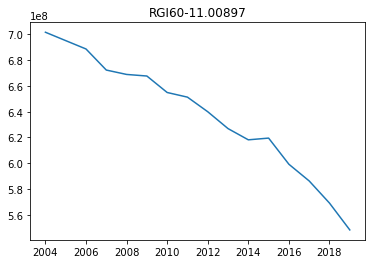

In [35]:
plt.plot(ds_hist.calendar_year, ds_hist.volume.isel(rgi_id=0))
plt.title(ds_hist.isel(rgi_id=0).rgi_id.values)

Text(0.5, 1.0, 'RGI60-11.01450')

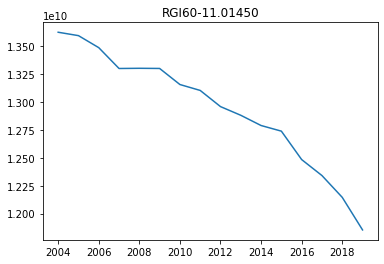

In [36]:
plt.plot(ds_hist.calendar_year, ds_hist.volume.isel(rgi_id=-1))
plt.title(ds_hist.isel(rgi_id=-1).rgi_id.values)

If we use as baseline_climate `W5E5` or `GSWP3_W5E5`, we do not need to do any bias correction, when we use the climate data from ISIMIP3b. This is because ISIMIP3b was internally bias-corrected to `W5E5` (add link). 

TODO: 

- add mu_star, prcp_fac to run_from_climate output files?
- add simplified only monthly `process_isimip_data` from `MBsandbox` to OGGM:
    - need ISIMIP3b test file 
    - the flattened ISIMIP3b files (https://cluster.klima.uni-bremen.de/~lschuster/isimip3b_flat/flat/monthly/) should go to ~oggm/ ... ???
- do projection run with isimip data

## Other stuff from prepro level that is not so important for the notebook example workflow probably

In [32]:
dynamic_spinup = False #'volume' #False
dynamic_spinup_start_year = 1901




In [33]:
# Which model?
if evolution_model == 'massredis':
    from oggm.core.flowline import MassRedistributionCurveModel
    evolution_model = MassRedistributionCurveModel
else:
    from oggm.core.flowline import FluxBasedModel
    evolution_model = FluxBasedModel

# OK - run
if dynamic_spinup:
    if y0 > dynamic_spinup_start_year:
        dynamic_spinup_start_year = y0
    workflow.execute_entity_task(tasks.run_dynamic_spinup, gdirs,
                                 evolution_model=evolution_model,
                                 minimise_for=dynamic_spinup,
                                 spinup_start_yr=dynamic_spinup_start_year,
                                 output_filesuffix='_dynamic_spinup',
                                 )
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                 min_ys=y0, ye=ye,
                                 evolution_model=evolution_model,
                                 init_model_filesuffix='_dynamic_spinup',
                                 output_filesuffix='_hist_spin')
    workflow.execute_entity_task(tasks.merge_consecutive_run_outputs, gdirs,
                                 input_filesuffix_1='_dynamic_spinup',
                                 input_filesuffix_2='_hist_spin',
                                 output_filesuffix='_historical_spinup',
                                 delete_input=True)

workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                             min_ys=y0, ye=ye,
                             evolution_model=evolution_model,
                             output_filesuffix='_historical') 

2022-05-17 17:10:42: oggm.workflow: Execute entity tasks [run_from_climate_data] on 2 glaciers


In [34]:


if dynamic_spinup:
    opath = os.path.join(sum_dir, f'historical_spinup_run_output_{rgi_reg}.nc')
    ds_hist_spinup = utils.compile_run_output(gdirs, path=opath,
                             input_filesuffix='_historical_spinup')

2022-05-17 17:10:43: oggm.utils: Applying global task compile_run_output on 2 glaciers
2022-05-17 17:10:43: oggm.utils: Applying compile_run_output on 2 gdirs.


In [35]:
plt.plot(ds_hist_spinup.calendar_year, ds_hist_spinup.volume.isel(rgi_id=1))
plt.title(ds_hist_spinup.isel(rgi_id=1).rgi_id.values)

NameError: name 'ds_hist_spinup' is not defined

### OLD stuff

In [ ]:
# Climate
        workflow.execute_entity_task(tasks.process_climate_data, gdirs)



        # Inversion: we match the consensus
        filter = border >= 20
        workflow.calibrate_inversion_from_consensus(gdirs,
                                                    apply_fs_on_mismatch=True,
                                                    error_on_mismatch=False,
                                                    filter_inversion_output=filter)

        # Do we want to match geodetic estimates?
        # This affects only the bias so we can actually do this *after*
        # the inversion, but we really want to take calving into account here
        if match_regional_geodetic_mb:
            opath = os.path.join(sum_dir, 'fixed_geometry_mass_balance_'
                                          'before_match_{}.csv'.format(rgi_reg))
            utils.compile_fixed_geometry_mass_balance(gdirs, path=opath)
            workflow.match_regional_geodetic_mb(gdirs, rgi_reg=rgi_reg,
                                                dataset=match_regional_geodetic_mb)

        # We get ready for modelling
        if border >= 20:
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)
        else:
            log.workflow('L3: for map border values < 20, wont initialize glaciers '
                         'for the run.')
        # Glacier stats
        opath = os.path.join(sum_dir, 'glacier_statistics_{}.csv'.format(rgi_reg))
        utils.compile_glacier_statistics(gdirs, path=opath)
        opath = os.path.join(sum_dir, 'climate_statistics_{}.csv'.format(rgi_reg))
        utils.compile_climate_statistics(gdirs, path=opath)
        opath = os.path.join(sum_dir, 'fixed_geometry_mass_balance_{}.csv'.format(rgi_reg))
        utils.compile_fixed_geometry_mass_balance(gdirs, path=opath)

        # L3 OK - compress all in output directory
        log.workflow('L3 done. Writing to tar...')
        level_base_dir = os.path.join(output_base_dir, 'L3')
        workflow.execute_entity_task(utils.gdir_to_tar, gdirs, delete=False,
                                     base_dir=level_base_dir)
        utils.base_dir_to_tar(level_base_dir)
        if max_level == 3:
            _time_log()
            return
        if border < 20:
            log.workflow('L3: for map border values < 20, wont compute L4 and L5.')
            _time_log()
            return

        # is needed to copy some files for L4 and L5
        sum_dir_L3 = sum_dir

    # L4 - No tasks: add some stats for consistency and make the dirs small
    if start_level <= 3:
        sum_dir = os.path.join(output_base_dir, 'L4', 'summary')
        utils.mkdir(sum_dir)

        # Copy L3 files for consistency
        for bn in ['glacier_statistics', 'climate_statistics',
                   'fixed_geometry_mass_balance']:
            if start_level < 3:
                ipath = os.path.join(sum_dir_L3, bn + '_{}.csv'.format(rgi_reg))
            else:
                ipath = file_downloader(os.path.join(
                    get_prepro_base_url(base_url=start_base_url,
                                        rgi_version=rgi_version, border=border,
                                        prepro_level=start_level), 'summary',
                    bn + '_{}.csv'.format(rgi_reg)))

            opath = os.path.join(sum_dir, bn + '_{}.csv'.format(rgi_reg))
            shutil.copyfile(ipath, opath)

        # Copy mini data to new dir
        mini_base_dir = os.path.join(working_dir, 'mini_perglacier',
                                     'RGI{}'.format(rgi_version),
                                     'b_{:03d}'.format(border))
        mini_gdirs = workflow.execute_entity_task(tasks.copy_to_basedir, gdirs,
                                                  base_dir=mini_base_dir)

        # L4 OK - compress all in output directory
        log.workflow('L4 done. Writing to tar...')
        level_base_dir = os.path.join(output_base_dir, 'L4')
        workflow.execute_entity_task(utils.gdir_to_tar, mini_gdirs, delete=False,
                                     base_dir=level_base_dir)
        utils.base_dir_to_tar(level_base_dir)
        if max_level == 4:
            _time_log()
            return

        # use mini_gdirs for L5
        gdirs = mini_gdirs

    # L5 - spinup run in mini gdirs
    # Get end date. The first gdir might have blown up, try some others
    i = 0
    while True:
        if i >= len(gdirs):
            raise RuntimeError('Found no valid glaciers!')
        try:
            y0 = gdirs[i].get_climate_info()['baseline_hydro_yr_0']
            # One adds 1 because the run ends at the end of the year
            ye = gdirs[i].get_climate_info()['baseline_hydro_yr_1'] + 1
            break
        except BaseException:
            i += 1

    # Which model?
    if evolution_model == 'massredis':
        from oggm.core.flowline import MassRedistributionCurveModel
        evolution_model = MassRedistributionCurveModel
    else:
        from oggm.core.flowline import FluxBasedModel
        evolution_model = FluxBasedModel

    # OK - run
    if dynamic_spinup:
        if y0 > dynamic_spinup_start_year:
            dynamic_spinup_start_year = y0
        workflow.execute_entity_task(tasks.run_dynamic_spinup, gdirs,
                                     evolution_model=evolution_model,
                                     minimise_for=dynamic_spinup,
                                     spinup_start_yr=dynamic_spinup_start_year,
                                     output_filesuffix='_dynamic_spinup',
                                     )
        workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                     min_ys=y0, ye=ye,
                                     evolution_model=evolution_model,
                                     init_model_filesuffix='_dynamic_spinup',
                                     output_filesuffix='_hist_spin')
        workflow.execute_entity_task(tasks.merge_consecutive_run_outputs, gdirs,
                                     input_filesuffix_1='_dynamic_spinup',
                                     input_filesuffix_2='_hist_spin',
                                     output_filesuffix='_historical_spinup',
                                     delete_input=True)

    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                 min_ys=y0, ye=ye,
                                 evolution_model=evolution_model,
                                 output_filesuffix='_historical')

    # Now compile the output
    sum_dir = os.path.join(output_base_dir, 'L5', 'summary')
    utils.mkdir(sum_dir)
    opath = os.path.join(sum_dir, f'historical_run_output_{rgi_reg}.nc')
    utils.compile_run_output(gdirs, path=opath, input_filesuffix='_historical')

    if dynamic_spinup:
        opath = os.path.join(sum_dir, f'historical_spinup_run_output_{rgi_reg}.nc')
        utils.compile_run_output(gdirs, path=opath,
                                 input_filesuffix='_historical_spinup')

    # Glacier statistics we recompute here for error analysis
    opath = os.path.join(sum_dir, 'glacier_statistics_{}.csv'.format(rgi_reg))
    utils.compile_glacier_statistics(gdirs, path=opath)

    # Other stats for consistency
    for bn in ['climate_statistics', 'fixed_geometry_mass_balance']:
        if start_level < 3:
            ipath = os.path.join(sum_dir_L3, bn + '_{}.csv'.format(rgi_reg))
        else:
            ipath = file_downloader(os.path.join(
                get_prepro_base_url(base_url=start_base_url,
                                    rgi_version=rgi_version, border=border,
                                    prepro_level=start_level), 'summary',
                bn + '_{}.csv'.format(rgi_reg)))
        opath = os.path.join(sum_dir, bn + '_{}.csv'.format(rgi_reg))
        shutil.copyfile(ipath, opath)

    # Add the extended files
    pf = os.path.join(sum_dir, 'historical_run_output_{}.nc'.format(rgi_reg))
    mf = os.path.join(sum_dir, 'fixed_geometry_mass_balance_{}.csv'.format(rgi_reg))
    # This is crucial - extending calving only possible with L3 data!!!
    if start_level < 3:
        sf = os.path.join(sum_dir_L3, 'glacier_statistics_{}.csv'.format(rgi_reg))
    else:
        sf = file_downloader(os.path.join(
            get_prepro_base_url(base_url=start_base_url,
                                rgi_version=rgi_version, border=border,
                                prepro_level=start_level), 'summary',
            'glacier_statistics_{}.csv'.format(rgi_reg)))
    opath = os.path.join(sum_dir, 'historical_run_output_extended_{}.nc'.format(rgi_reg))
    utils.extend_past_climate_run(past_run_file=pf,
                                  fixed_geometry_mb_file=mf,
                                  glacier_statistics_file=sf,
                                  path=opath)

    # L5 OK - compress all in output directory
    log.workflow('L5 done. Writing to tar...')
    level_base_dir = os.path.join(output_base_dir, 'L5')
    workflow.execute_entity_task(utils.gdir_to_tar, gdirs, delete=False,
                                 base_dir=level_base_dir)
    utils.base_dir_to_tar(level_base_dir)

    _time_log()

## geodetic data from Hugonnet et al. (2021)

In [40]:
use_per_region_files = False
if use_per_region_files:
    # you can download this yourself under https://www.sedoo.fr/theia-publication-products/?uuid=c428c5b9-df8f-4f86-9b75-e04c778e29b9 
    hugonnet_path = '/home/lilianschuster/Schreibtisch/PhD/hugonnet_et_al_2021_per_glacier_time_series/dh_{}_rgi60_pergla_rates.csv'
    rgi = {}
    pd_geodetic_l = {}
    for rgi in ['01','02','03','04','05','06','07','08','09','10','11','12', '13', '14', '15', '16', '17', '18', '19']:
        pd_geodetic_l[rgi] = pd.read_csv(hugonnet_path.format(rgi),  encoding='utf-7', index_col='rgiid')
        # we only want the measurements from 2000 to the end of 2019 
        pd_geodetic_l_20 = pd_geodetic_l[rgi].loc[pd_geodetic_l[rgi].period == '2000-01-01_2020-01-01']
        pd_geodetic_l_10_0 = pd_geodetic_l[rgi].loc[pd_geodetic_l[rgi].period == '2000-01-01_2010-01-01']
        pd_geodetic_l_10_1 = pd_geodetic_l[rgi].loc[pd_geodetic_l[rgi].period == '2010-01-01_2020-01-01']
        pd_geodetic_l[rgi] = pd.concat([pd_geodetic_l_20, pd_geodetic_l_10_0, pd_geodetic_l_10_1])
        pd_geodetic_l[rgi] = pd_geodetic_l[rgi].sort_values('rgiid')
        # concatenate all geodetic observations together that are reference glaciers with at least 5 msm in time period 2000 to 2019
    pd_geodetic = pd_geodetic_l['01']# [pd_geodetic_l['01'].index.isin(pd_wgms.columns.values)]
    for rgi in ['02','03','04','05','06','07','08','09','10','11','12', '13', '14', '15', '16', '17', '18', '19']:
        sel = pd_geodetic_l[rgi]#[pd_geodetic_l[rgi].index.isin(pd_wgms.columns.values)]
        pd_geodetic = pd.concat([pd_geodetic, sel])
    pd_geodetic.to_csv('hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv')
else:
    # we use now the corrected and filled dataset
    pd_geodetic = utils.get_geodetic_mb_dataframe()
    pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']

In [52]:
len(set(pd_geodetic.dropna().index))

210118

In [6]:
pd.read_csv(hugonnet_path.format(rgi),  encoding='utf-7', index_col='rgiid')

,period,area,dhdt,err_dhdt,dvoldt,err_dvoldt,dmdt,err_dmdt,dmdtda,err_dmdtda,perc_area_meas,perc_area_res,valid_obs,valid_obs_py,reg
rgiid,,,,,,,,,,,,,,,
RGI60-19.00001,2000-01-01_2001-01-01,64608000.0,0.0490,2.8692,3166797.0,185376458.0,0.002692,0.157570,0.0417,2.4389,0.996,1.000,0.00,0.00,19
RGI60-19.00001,2000-01-01_2002-01-01,64608000.0,0.0332,1.3097,2145671.0,84614265.0,0.001824,0.071922,0.0282,1.1132,0.996,1.000,0.00,0.00,19
RGI60-19.00001,2000-01-01_2004-01-01,64608000.0,0.0487,0.6026,3143438.0,38935260.0,0.002672,0.033096,0.0414,0.5123,0.996,1.000,1.17,1.16,19
RGI60-19.00001,2000-01-01_2005-01-01,64608000.0,0.0016,0.5340,102991.0,34499998.0,0.000088,0.029325,0.0014,0.4539,0.996,1.000,2.17,2.16,19
RGI60-19.00001,2000-01-01_2010-01-01,64608000.0,-0.0534,0.3199,-3452384.0,20665638.0,-0.002935,0.017567,-0.0454,0.2719,0.996,1.000,4.40,4.20,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-19.02752,2016-01-01_2020-01-01,528000.0,-0.3660,1.4540,-193224.0,768177.0,-0.000164,0.000653,-0.3111,1.2376,0.981,0.981,0.54,0.54,19
RGI60-19.02752,2017-01-01_2018-01-01,528000.0,-0.3551,5.6545,-187504.0,2985716.0,-0.000159,0.002538,-0.3019,4.8068,0.981,0.981,0.31,0.31,19
RGI60-19.02752,2018-01-01_2019-01-01,528000.0,-0.3762,5.7605,-198636.0,3041675.0,-0.000169,0.002585,-0.3198,4.8969,0.981,0.981,0.00,0.00,19


In [134]:
# this is the specific mass balance for every glacier 
pd_geodetic.dmdtda.dropna() *1000 # this is in kg/m2/yr

rgiid
RGI60-01.00001     -12.8
RGI60-01.00002    -229.0
RGI60-01.00003    -797.9
RGI60-01.00004    -407.5
RGI60-01.00005      39.0
                   ...  
RGI60-19.02747    -676.5
RGI60-19.02749    -826.8
RGI60-19.02750    -411.7
RGI60-19.02751   -1836.9
RGI60-19.02752     -38.6
Name: dmdtda, Length: 210120, dtype: float64

- for some few glaciers, there are no geodetic measurements!

## calibration: 

- have to set the hydro_year to 1 (geodetic data corresponds to MB from Jan 2000 to Jan 2020)!!!

In [136]:
cfg.PARAMS['baseline_climate'] = 'CRU' #'ERA5'
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['prcp_scaling_factor'] = 2.5 # if ERA5 use maybe 1.6 ?!

In [143]:
def minimize_bias_geodetic_mu_star(x, gd_mb=None, mb_geodetic=None,
                           h=None, w=None, pf=2.5,
                           ys=np.arange(2000, 2020, 1),
                           ):
    """ calibrates the melt factor (melt_f/mu_star) by getting the bias to zero
    comparing modelled mean specific mass balance between 2000 and 2020 to
    observed geodetic data

    Parameters
    ----------
    x : float
        what is optimised (here the melt_f/mu_star)
    gd_mb: class instance
        instantiated class of Pastmassbalane, this is updated by mu_star
    mb_geodetic: float
         geodetic mass balance between 2000-2020 of the instantiated glacier
    h: np.array
        heights of the instantiated glacier
    w: np.array
        widths of the instantiated glacier
    pf: float
        precipitation scaling factor
        default is 2.5
    ys: np.array
        years for which specific mass balance is computed
        default is 2000--2019

    Returns
    -------
    float
        bias: modeled mass balance mean - reference mean (geodetic)
        if absolute_bias = True:  np.abs(bias) is returned

    """
    gd_mb.mu_star = x

    gd_mb.prcp_fac = pf
    mb_specific = gd_mb.get_specific_mb(heights=h,
                                        widths=w,
                                        year=ys).mean()
    bias_calib = np.mean(mb_specific - mb_geodetic)

    return bias_calib

In [158]:
df = ['RGI60-11.00897']
#df = ['RGI60-11.01450']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
gdir = gdirs[0]
oggm.core.climate.process_climate_data(gdir)

2021-05-12 10:08:55: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-05-12 10:08:55: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers


**important**: 
- we need to set the residual/bias to zero in PastMassBalance


In [159]:
# we use here the default OGGM mass balance model! 
gd_mb = massbalance.PastMassBalance(gdir, mu_star=200, # just set it to any value, this will be calibrated later
                                    bias=0, # set to zero!
                                    check_calib_params=False)
# set the precipitation factor to a constant value of 
gd_mb.prcp_fac = cfg.PARAMS['prcp_scaling_factor'] # just to make sure that the right prcp factor is applied 
# get the geodetic measurements of that glacier
mb_geodetic = pd_geodetic.loc[df].dmdtda.values *1000

# calibration time period
ys = np.arange(2000, 2020)
h, w = gdir.get_inversion_flowline_hw()
# find the optimal melt factor that minimises the bias of the geodetic measurements (2000-2019)
# allow the melt factor to be between 10 and 1000, 
melt_f = scipy.optimize.brentq(minimize_bias_geodetic_mu_star, 10, 1000,  # allow the melt factor to be between 10 and 1000, 
                      xtol = 0.01, args=(gd_mb, mb_geodetic, h, w, cfg.PARAMS['prcp_scaling_factor'],
                                         ys), # which years should be used: normally 2000-2019 (but for some climate datasets there is no 2019 available)
                                    disp=True)
# the mu_star is the melt factor ...                          
print(melt_f)
# you can save the calibrated melt_f/mu_star for the glacier or you can directly do projections, or whatever with the new calibrated mu_star / melt_f


184.32415325809973


## check and validation
**here we only check if the calibration has worked and compare it to the direct glaciological measurements if there are any available for that glacier**

In [160]:
# change in the mass balance model instance the mu_star to the new calibrated mu_star/melt_f
gd_mb.mu_star = melt_f
# compute the specific mass balance for that glacier using the calibrated melt_f
mb_specific = gd_mb.get_specific_mb(heights=h,
                                    widths=w,
                                    year=ys)
np.testing.assert_allclose(mb_geodetic, mb_specific.mean(), rtol=1e-3)

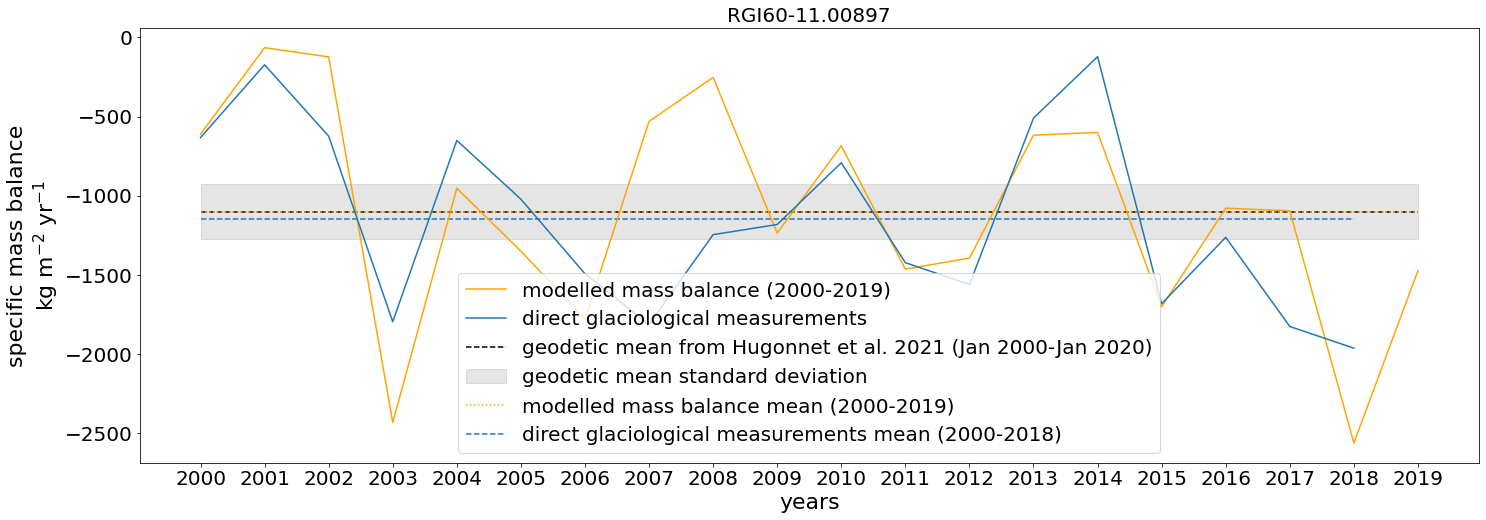

In [161]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.figure(figsize=(24,8))
plt.hlines(mb_geodetic, label = 'geodetic mean from Hugonnet et al. 2021 (Jan 2000-Jan 2020)', xmin=2000, xmax = 2019,
            ls = '--',
            color = 'black')

# just for visualization: standard deviation from the Hugonnet data 
mb_geodetic_std = pd_geodetic.loc[df].err_dmdtda.values *1000
plt.fill_between(x=ys,
                 y1=np.repeat(mb_geodetic, len(ys))-mb_geodetic_std,
                 y2=np.repeat(mb_geodetic, len(ys))+mb_geodetic_std,
                 alpha = 0.1, color = 'black', label = 'geodetic mean standard deviation')

plt.plot(ys, mb_specific, label='modelled mass balance (2000-2019)', color='orange')
plt.hlines(mb_specific.mean(), label = 'modelled mass balance mean (2000-2019)',xmin=2000, xmax = 2019,
           ls = ':', color = 'orange')



try:
    plt.plot(ys[:-1], gdir.get_ref_mb_data()['ANNUAL_BALANCE'].loc[2000:],label = 'direct glaciological measurements')
    plt.hlines(gdir.get_ref_mb_data()['ANNUAL_BALANCE'].loc[2000:].values.mean(),
              xmin=2000, xmax = gdir.get_ref_mb_data()['ANNUAL_BALANCE'].index[-1],
                label = 'direct glaciological measurements mean (2000-2018)', ls = '--')

except:
    pass

plt.xlabel('years')
plt.ylabel('specific mass balance\nkg m$^{-2}$ yr$^{-1}$')
plt.xticks(ys)
plt.legend();
plt.title(gdir.rgi_id);

- if you want to use the new calibration to do projections and use e.g. `run_from_climate_data`, we need to adapt the function because the new calibrated `mu_star` has to be included
(I use my own set of functions because I had to change more stuff)
    - **but maybe you find a better way that OGGM uses directly the internal new calibrated melt_f** (in my case I wanted to change other stuff like the precipitation factor, so this was not possible)
- similar as in `run_from_climate_data_TIModel`, but you only need to change the mu_star/melt_f and not precipitation factor, so you won't need to defn-> https://github.com/OGGM/massbalance-sandbox/blob/master/MBsandbox/wip/projections_bayescalibration.py#L63
- for the projections I use then `inversion_and_run_from_climate_with_bayes_mb_params` here (some bayesian calibration stuff included here, but it might help to see how to do the projections: -> https://github.com/OGGM/massbalance-sandbox/blob/15a26ec549e41c0d5506237f5fb2fb5d0bae5a07/MBsandbox/wip/projections_bayescalibration.py#L1104